## Example notebook for downsampling data with `ROMspline`

In [1]:
# Import necessary modules
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Uncomment next two lines if romSpline is not in your PYTHONPATH
# import sys
# sys.path.append(<path to romSpline>)

import romSpline

In [2]:
# Make up some test data to show how to use the code.
x = np.linspace(-1, 1, 100001)

def f(x):
    return 100.*( (1.+x)*np.sin(5.*(x-0.2)**2) + np.exp(-(x-0.5)**2/2./0.01)*np.sin(100*x) )

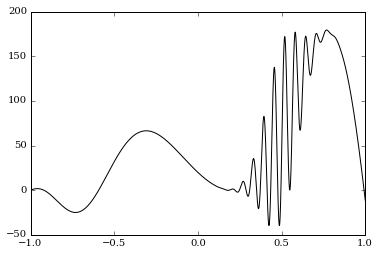

In [3]:
# Plot the test data to see how it looks.
plt.plot(x, f(x), 'k-');

In [4]:
# Create a reduced-order spline by making an instance of the ReducedOrderSpline class.
spline = romSpline.ReducedOrderSpline(x, f(x), verbose=True)

# Additional options include:
#     deg -- degree of interpolating spline polynomials (default is 5)
#     tol -- tolerance of greedy algorithm (default is 1e-6)
#     rel -- use relative errors if True (default is False)


Size 	Error
6 	109.923909402
7 	200.735648108
8 	2378.48939455
9 	1084.67620686
10 	722.724632227
11 	491.921200922
12 	658.498153554
13 	345.494055596
14 	289.79994798
15 	400.056305789
16 	480.881557483
17 	473.89818132
18 	339.760656984
19 	312.348775991
20 	298.402466704
21 	293.191345999
22 	221.48957756
23 	214.196073872
24 	272.707510515
25 	207.458156046
26 	160.726679878
27 	139.574873685
28 	66.6195064279
29 	51.95872435
30 	40.2956373144
31 	30.4583285679
32 	26.2806404373
33 	23.7367034642
34 	18.8089851872
35 	17.7907446738
36 	13.506634482
37 	11.6732677074
38 	6.88675206695
39 	6.86892121717
40 	5.09704029615
41 	4.89234654309
42 	3.26935478145
43 	3.11819667034
44 	2.63016942199
45 	2.54223206129
46 	2.53868769459
47 	2.52612135534
48 	1.99661662702
49 	1.98323345886
50 	1.42355380649
51 	0.921708051205
52 	0.896236023613
53 	0.588439577505
54 	0.44610967306
55 	0.413508450138
56 	0.880269498547
57 	0.559703265237
58 	0.454164087744
59 	0.384660270789
60 	0.32582194861

In [5]:
# Because data, namely, x and f(x), are given then the class goes ahead and builds the
# reduced-order spline via a greedy algorithm. The number of optimal points and the 
# resulting compression factor are:
print "Number of optimal points:", spline.size
print "Compression factor:", spline.compression

Number of optimal points: 448
Compression factor: 223.216517857


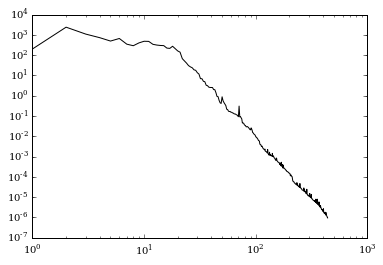

In [6]:
# Plot the max L-infinity errors that were found in building the "optimal" spline.
# Notice that the decay is polynomial (power is deg+1) and not exponential. 
# This is because the spline is only smooth to the degree of the polynomial used. 
# For this reason, it's good not to set the tolerance too high (e.g., numerical round-off)
# as the time to generate spline might be impractically long.
plt.loglog(spline.errors, 'k-');

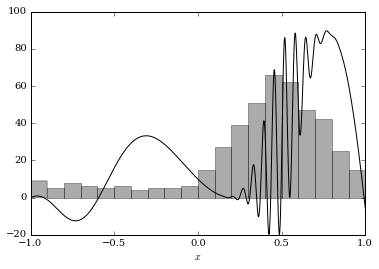

In [7]:
# The distribution of the "optimal" knots is not uniform. Generally speaking, the
# density of knots is highest around the more variable data.
plt.hist(spline.knots, 20, color='k', alpha=0.33)
plt.plot(x, f(x)/2., 'k-')
plt.xlabel('$x$');

In [8]:
# To evaluate the spline let's first create an array of new samples
import random
xx = np.sort([random.uniform(x.min(), x.max()) for ii in range(10000)])

# Then you can use "eval" to evaluate the spline
y1 = spline.eval(xx)

# ...or do the following:
y2 = spline(xx)

# These are equivalent -- their difference is an array of zeros
print np.all(np.abs(y1-y2) == 0.)

True


In [9]:
# You can write the relevant spline interpolant data to HDF5 format
spline.write('test1.h5')

In [10]:
# Next, let's pretend you've already saved the reduced-order spline data to file 
# and want to evaluate the interpolant given only a previously created data file. In this case, do the following:
s = romSpline.ReducedOrderSpline()
s.read('test1.h5')

In [11]:
# You can check that data was loaded by evaluating the spline at the xx samples
s.eval(xx)

array([  1.10090019e-02,   1.84970314e-02,   3.09020873e-02, ...,
        -1.12837151e+01,  -1.14625458e+01,  -1.15581485e+01])

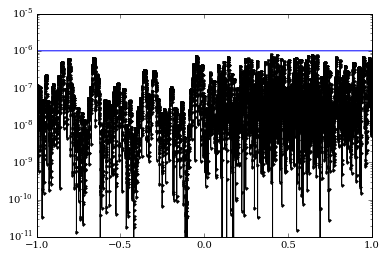

In [12]:
# Let's plot the difference bewteen the original function and the spline at xx.
# Also plotted in blue is the default tolerance (1e-6) used by the greedy algorithm
plt.semilogy(xx, np.abs(f(xx)-s(xx)), 'k.-', xx, 1e-6*np.ones(xx.size), 'b-');
plt.ylim(1e-11, 1e-5);

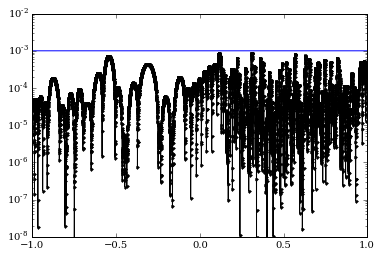

In [13]:
# We can rerun the greedy algorithm to make a spline with a different tolerance, for example.
# Using the same object "spline" (or you can create a new one), we run the "greedy" method
spline.greedy(x, f(x), tol=1e-3)

# ...and plot the spline errors at the xx samples like we did earlier
plt.semilogy(xx, np.abs(f(xx)-spline.eval(xx)), 'k.-', xx, 1e-3*np.ones(xx.size), 'b-');
plt.ylim(1e-8, 1e-2);

In [14]:
# And you can write this spline data to file, too
spline.write('test2.h5')

The compression factor is: 1562.515625
The relative tolerance requested is 0.001
The absolute tolerance used is: 0.179373340905 0.179373340905


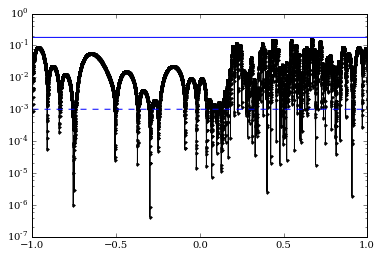

In [15]:
# In addition, you can build a reduced-order spline where the tolerance is relative 
# to the maximum of the absolute value of the data by using the rel option:
spline.greedy(x, f(x), tol=1e-3, rel=True)

print "The compression factor is:", spline.compression
print "The relative tolerance requested is", spline._tol
print "The absolute tolerance used is:", spline.tol, spline._tol * np.max(np.abs(f(x)))

plt.semilogy(xx, np.abs(f(xx)-spline.eval(xx)), 'k.-', 
             xx, spline.tol*np.ones(xx.size), 'b-',
            xx, spline._tol*np.ones(xx.size), 'b--');

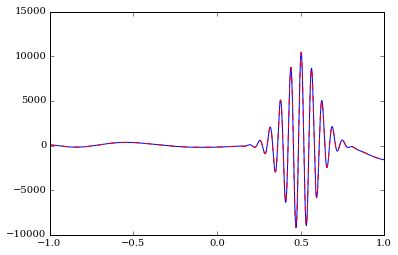

In [16]:
# One last comment. You can compute derivatives of the interpolated function, too. 
# For the first derivative just type:
spline = romSpline.ReducedOrderSpline(x, f(x), tol=1e-3)
spline.eval(x, dx=1)

# Let's compare this to building a spline of the analytic derivative:
def dfdx(x):
    """Analytic derivative of f(x) test data"""
    a = 10.*(-0.2+x)*(1.+x)*np.cos(5.*(-0.2 + x)**2)
    b = 100.*np.exp(-50.*(-0.5+x)**2)*np.cos(100.*x)
    c = np.sin(5.*(-0.2+x)**2)
    d = -100.*np.exp(-50.*(-0.5+x)**2)*(-0.5+x)*np.sin(100.*x)
    return 100.*(a+b+c+d)

dspline = romSpline.ReducedOrderSpline(x, dfdx(x), tol=1e-3)

# Plot the two splines. By the eyeball norm they both agree...
plt.plot(x, spline(x, dx=1), 'b-');
plt.plot(x, dspline(x), 'r--');

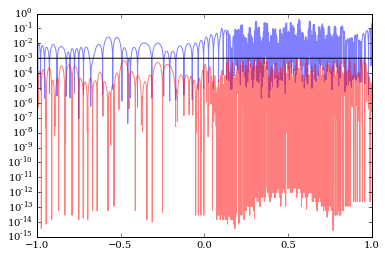

In [17]:
#...but building the reduced-order spline from the analytic derivative
# is more accurate than computing the derivative of the reduced-order spline
plt.semilogy(x, np.abs(spline(x, dx=1)-dfdx(x)), 'b-', alpha=0.5);
plt.semilogy(x, np.abs(dspline(x)-dfdx(x)), 'r-', alpha=0.5);
plt.semilogy(x, dspline._tol*np.ones(x.size), 'k-');